In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from getdist import plots, MCSamples
import getdist
import cosmolopy.distance as distance
import time

In [10]:
def mu(datos,w):
    '''
    variables independientes:
    datos[0]=mb
    datos[1]=x1
    datos[2]=color
    
    parámetros:
    w[0]=alpha
    w[1]=beta
    w[2]=Mb
    w[3]=om_M
    '''
    return datos['mb'] - (w[2] - w[0]*datos['x1'] + w[1]*datos['color'])


def mulcdm(om_M,zcmb):
    cosmo={'omega_M_0':om_M, 'omega_lambda_0':1-om_M,'omega_k_0':0.0,'h':0.7}
    return 5*np.log10(distance.luminosity_distance(zcmb,**cosmo)*1e6/10)


# def covsn(datos,w):
#     diag=datos['dmb']**2+(w[0]*datos['dx1'])**2+(w[1]*datos['dcolor'])**2+2*w[0]*datos['cov_m_s']-2*w[1]*datos['cov_m_c']-2*w[0]*w[1]*datos['cov_s_c']
#     return np.diag(diag)+mat0+w[0]**2*mat1+w[1]**2*mat2+2*w[0]*mat3-2*w[1]*mat4-2*w[0]*w[1]*mat5

def covsn(datos,w):
    return mat0+mat1+mat2+mat3+mat4+mat5

#Intento de likelihood con matriz de covarianza
    
# def lnl(datos,modelo,w):
#     '''
#     variables independientes:
#     datos[0]=mb
#     datos[1]=x1
#     datos[2]=color
    
#     parámetros:
#     w[0]=alpha
#     w[1]=beta
#     w[2]=Mb
#     w[3]=om_M
#     '''
#     cov=covsn(datos,w)
#     return -np.matmul(np.matmul((mu(datos,w)-mulcdm(w[3],datos['zcmb'])).T,np.linalg.inv(cov)),(mu(datos,w)-mulcdm(w[3],datos['zcmb'])))
    

def lnl(datos,modelo,param):
    '''
    logaritmo natural del likelihood. Se considera un likelihood con distribución normal.
    
    datos[0]=variables independientes (debe concordar con las variables que acepta el modelo proporcionado)
    datos[1]=variable dependiente
    datos[2]=desviación de variable dependiente
    '''
    cov=covsn(datos,param)
    return -1/2*np.sum(((mulcdm(param[3],datos['zcmb'])-modelo(datos,param))/np.diag(cov))**2)



def lnprior(param,extremos):
    '''
    logaritmo natural de prior plano. Se considera un prior PLANO donde todos los puntos del espacio de 
    parámetros tienen la misma probabilidad, y los puntos fuera del espacio se les asigna 0.
    
    param: arreglo con los parámetros.
    extremos: matriz tamaño 2 x len(param) en la que se encuentran los extremos inferior y superior a priori 
    de los parámetros, estos limitan un espacio de parámetros cuadrado, cúbico, etc.
    '''
    
    lnpr=np.zeros(len(param))
    for i in range(len(param)):
        if(extremos[i][0]<param[i]<extremos[i][1]):
            lnpr[i]=-1*np.log(1/(extremos[i][1]-extremos[i][0]))
        else:
            lnpr[i]=-1*np.inf
    return sum(lnpr)


def montecarlo(datos,modelo,desvp,pold,extremos,it,maxit):
    '''
    Esta función sirve para priors PLANOS
    
    datos: matriz que guarda los datos experimentales y desviación de la variable independiente
    modelo: modelo que se quiere ajustar a los datos
    desvp: desviación de distribución de la vecindad donde se buscarán nuevos puntos para iterar
    pold: primera aproximación
    extremos: límites inferiores y superiores (a priori) para cada paŕametro
    it: puntos aceptados deseados
    maxit: máximo de iteraciones permitidas
    '''
    cadena=[]
    lnpostold=lnl(datos,modelo,pold)+lnprior(pold,extremos)
    cadena.append(np.append(pold,lnpostold))
    nosus=0
    sus=0
    for i in range(maxit):
        random=np.random.randn(len(pold))
        pnew=desvp*random+pold        
        lnpostnew=lnl(datos,modelo,pnew)+lnprior(pnew,extremos)
        if(lnpostnew>lnpostold or np.exp(lnpostnew-lnpostold)>np.random.uniform()):
            cadena.append(np.append(pnew,lnpostnew))
            pold=pnew
            lnpostold=lnpostnew
            sus+=1
            if(sus==it):
                break
        else:
            cadena.append(np.append(pnew,lnpostnew)) #si queremos sólo los puntos aceptados comentamos esta línea
            nosus+=1
    return cadena,nosus

def montecarlo2(datos,modelo,desvp,pold,extremos,it,maxit):
    '''
    Esta función sirve para priors PLANOS
    
    datos: matriz que guarda los datos experimentales y desviación de la variable independiente
    modelo: modelo que se quiere ajustar a los datos
    desvp: desviación de distribución de la vecindad donde se buscarán nuevos puntos para iterar
    pold: primera aproximación
    extremos: límites inferiores y superiores (a priori) para cada paŕametro
    it: puntos aceptados deseados
    maxit: máximo de iteraciones permitidas
    '''
    cadena=[]
    lnpostold=lnl(datos,modelo,pold)+lnprior(pold,extremos)
    cadena.append(np.append(pold,lnpostold))
    nosus=0
    sus=0
    for i in range(maxit):
        random=np.random.randn(len(pold))
        pnew=desvp*random+pold        
        lnpostnew=lnl(datos,modelo,pnew)+lnprior(pnew,extremos)
        if(lnpostnew>lnpostold or np.exp(lnpostnew-lnpostold)>np.random.uniform()):
            cadena.append(np.append(pnew,lnpostnew))
            pold=pnew
            lnpostold=lnpostnew
            sus+=1
            if(sus==it):
                break
        else:
            cadena.append(np.append(pnew,lnpostnew)) #si queremos sólo los puntos aceptados comentamos esta línea
            nosus+=1
    return cadena,nosus



In [11]:
mat0=pd.read_csv("../Semana7/jla_likelihood_v6/data/jla_v0_covmatrix.dat",sep=" ").to_numpy().reshape(740, 740)
mat1=pd.read_csv("../Semana7/jla_likelihood_v6/data/jla_v0a_covmatrix.dat",sep=" ").to_numpy().reshape(740, 740)
mat2=pd.read_csv("../Semana7/jla_likelihood_v6/data/jla_v0b_covmatrix.dat",sep=" ").to_numpy().reshape(740, 740)
mat3=pd.read_csv("../Semana7/jla_likelihood_v6/data/jla_va_covmatrix.dat",sep=" ").to_numpy().reshape(740, 740)
mat4=pd.read_csv("../Semana7/jla_likelihood_v6/data/jla_vab_covmatrix.dat",sep=" ").to_numpy().reshape(740, 740)
mat5=pd.read_csv("../Semana7/jla_likelihood_v6/data/jla_vb_covmatrix.dat",sep=" ").to_numpy().reshape(740, 740)

In [12]:
datos=pd.read_csv("../Semana7/jla_likelihood_v6/data/jla_lcparams.txt", sep=" ")#.sort_values(by = "zcmb")

In [54]:
#nombres de los parámetros
paramnames=['α','β','M_b','Ω_M']
#se fijan extremos del espacio en el que se busca el valor de los parámetros
ext=np.array([[0.,5.],[0.,6.],[-25.,-15.],[0.,5.]])
#cantidad de cadenas a correr
ncadenas=3
#Genera puntos aleatorios como aproximaciones iniciales en el espacio delimitado anteriormente
aprox=[[np.random.uniform(ext[j][0],ext[j][1]) for j in range(len(ext))] for i in range(ncadenas)]

In [55]:
res=[]

for i in range(len(aprox)):
    start_time = time.time()
    res.append(montecarlo2(datos,mu,0.05,aprox[i],ext,3000,3000))
    print("Tiempo: %.3f seconds" % (time.time() - start_time))

Tiempo: 88.965 seconds
Tiempo: 92.676 seconds
Tiempo: 90.272 seconds


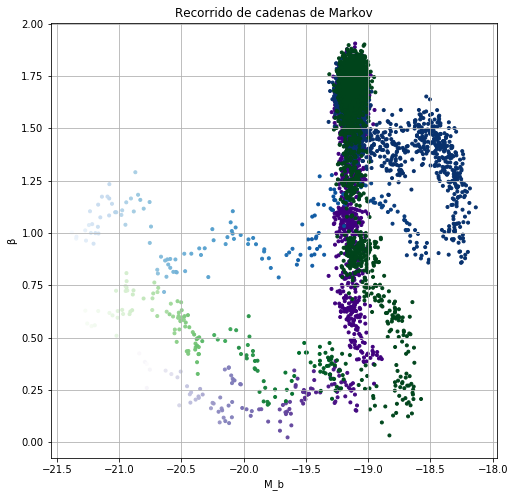

In [56]:
#Visualización de cadenas
cmaps=['Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
fig,ax=plt.subplots(figsize=(8, 8))
for i in range(len(aprox)):
    ax.scatter(np.array(res[i][0])[:,2],np.array(res[i][0])[:,1],c=np.array(res[i][0])[:,4],cmap=cmaps[i],marker=".")

ax.set_xlabel(paramnames[2])
ax.set_ylabel(paramnames[1])
ax.set_title('Recorrido de cadenas de Markov') 
plt.grid()

In [57]:
#Visualización del avance de cada parámetro en las 5 cadenas

# for j in range(len(res)):
#     fig, ax = plt.subplots(len(ext))
#     for i in range(len(ext)):
#         ax[i].plot(range(len(np.array(res[j][0])[:,i])),np.array(res[j][0])[:,i])
#         ax[i].set_ylabel('Parámetro '+str(i+1))
#     ax[i].set_xlabel('Iteraciones')
#     ax[i-len(ext)+1].set_title('Cadena '+str(j+1)) 

In [58]:
#Visualización de cada parámetro sin el burn
burnaux=700    #primeros n datos a eliminar
burn=len(res[0][0])-burnaux
promediosc=np.zeros([ncadenas,len(ext)])

for j in range(len(res)):
    fig, ax = plt.subplots(len(ext))
    for i in range(len(ext)):
        ax[i].plot(range(len(np.array(res[j][0])[:,i])-burn-1,len(np.array(res[j][0])[:,i])),np.array(res[j][0])[len(np.array(res[j][0])[:,i])-1-burn:,i])
        ax[i].set_ylabel('Parámetro '+str(i+1))
        promediosc[j][i]=np.mean(np.array(res[j][0])[len(np.array(res[j][0])[:,i])-1-burn:,i])
    ax[i].set_xlabel('Iteraciones')
    ax[i-len(ext)+1].set_title('Cadena '+str(j+1))
    plt.clf()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [59]:
#Se unen cadenas sin burn en un solo arreglo
unioncadenas=[]
for i in range(len(res)):
    for j in range(len(res[i][0])-burn):
        unioncadenas.append(res[i][0][j+burn])
unioncadenas=np.array(unioncadenas)

Text(0.5, 1.0, 'Cadenas unidas')

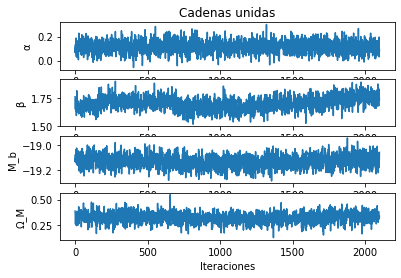

In [60]:
#Visualización de cada parámetro de la cadena unida
fig, ax = plt.subplots(len(ext))
for i in range(len(ext)):
    ax[i].plot(range(len(unioncadenas)),unioncadenas[:,i])
    ax[i].set_ylabel(paramnames[i])
ax[i].set_xlabel('Iteraciones')
ax[0].set_title('Cadenas unidas')

In [61]:
#Cálculo de promedios de cada parámetro
promedios=[np.mean(unioncadenas[:,i]) for i in range(len(ext))]
promedios

[0.11556858702920582,
 1.7060704180774429,
 -19.130148310822324,
 0.31957445769739906]

Removed no burn in


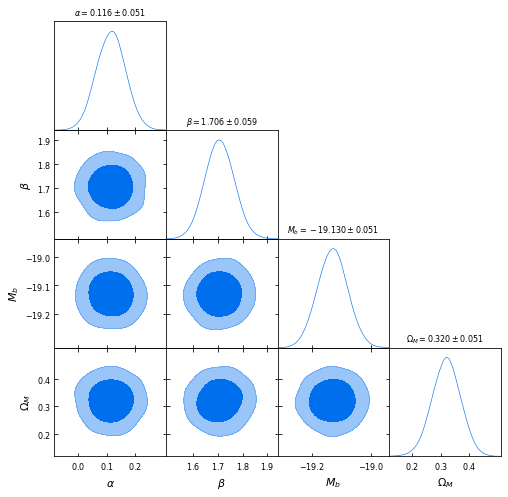

In [62]:
#Gráfica triangular
samples=MCSamples(samples=np.array(unioncadenas[:,(0,1,2,3)]),names=['alpha','beta','Mb','om_M'],labels=['α','β','M_b','\Omega _M'])
g = plots.get_subplot_plotter()
g.triangle_plot(samples, filled=True,title_limit=1)

In [83]:
#Criterio de convergencia de Gelman Rubin

def si2(cadena):
    '''
    Se introduce el arreglo de valores de la cadena de un solo parámetro sin burn
    '''
    media=np.mean(cadena)
    return 1/(len(cadena)-1)*np.sum((cadena-media)**2),media

def gelmanrubin(res):
    nparam=len(res[0][0][0])-1
    ncadenas=len(res)
    si2p=np.zeros([nparam,ncadenas])
    mediasp=np.zeros([nparam,ncadenas])
    s2=np.zeros(nparam)
    bn=np.zeros(nparam)
    sigmagorro=np.zeros(nparam)
    R=np.zeros(nparam)
    for i in range(nparam):
        for j in range(ncadenas):
            si2p[i][j],mediasp[i][j]=si2(np.array(res[j][0])[(len(res[j][0])-burn):,i])
        s2[i]=np.sum(si2p[i])/ncadenas
        bn[i]=1/(ncadenas-1)*np.sum((mediasp[i]-np.mean(mediasp[i]))**2)
        sigmagorro[i]=(len(np.array(res[j][0])[(len(res[j][0])-burn):,0])-1)/len(np.array(res[j][0])[(len(res[j][0])-burn):,0])*s2[i]+bn[i]
        R[i]=np.sqrt(sigmagorro[i]/s2[i])
        print("R=%.5f para "% R[i] +paramnames[i])
    return R


In [89]:
R=gelmanrubin(res)

R=0.99979 para α
R=1.11653 para β
R=1.00018 para M_b
R=1.00017 para Ω_M
